## DATASET

In [ ]:
from dataset_creation import getDataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train_blurred, x_train), (x_test_blurred, x_test)  = getDataset()

Resolution $32*32$

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# The dataset is already normalized
x_train[0].min(), x_train[0].max()

(0.0, 1.0)

Let's see some examples

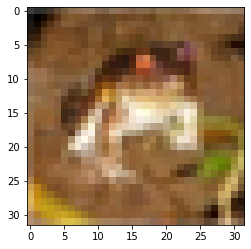

In [ ]:
plt.imshow(x_train[0])

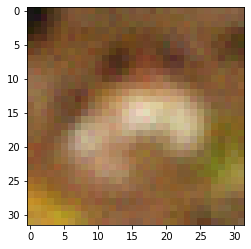

In [ ]:
plt.imshow(x_train_blurred[0])

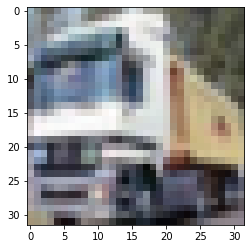

In [ ]:
plt.imshow(x_train[1])

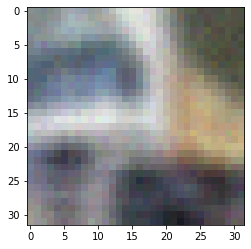

In [ ]:
plt.imshow(x_train_blurred[1])

## MODEL
Multi-level Wavelet CNN

https://towardsai.net/p/deep-learning/image-de-noising-using-deep-learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [ ]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [ ]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for IWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(32,32,3))

    cb_1 = Conv_block(num_filters=16)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=32)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=64)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=128)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=128)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=128)(cb_5)
    cb_5 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=128)(Add()([up, cb_4]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_3]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=32)(Add()([up, cb_2]))
    up = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=16)(Add()([up, cb_1]))
    up = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same", activation='sigmoid')(up)

    return Model(inputs=[input], outputs=[out])

In [ ]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_block (Conv_block)        (None, 32, 32, 16)   5088        ['input_1[0][0]']                
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 16, 16, 64)  0           ['conv_block[0][0]']             
 ling)                                                                                            
                                                                                                  
 conv_block_1 (Conv_block)      (None, 16, 16, 32)   36960       ['dwt_downsampling[0][0]']   

## TRAINING

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('MWCNN.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
hist = model.fit(x_train_blurred, x_train, epochs=15, validation_split=0.2, callbacks=[callback_checkpoint])

Epoch 1/15
1250/1250 [==============================] - 38s 18ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 2/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/15
1250/1250 [==============================] - 22s 18ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/15
1250/1250 [==============================] - 22s 18ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/15
1250/1250 [==============================] - 21s 17m

In [ ]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

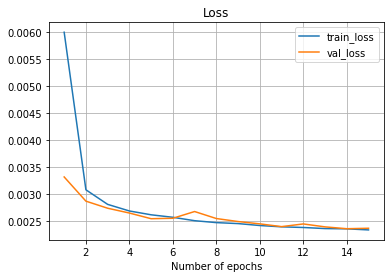

In [ ]:
plot_history(hist)

Final score on the test set. Better than Convolutional autoencoder.

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, model.predict(x_test_blurred)).numpy()

0.0023708928

## DATA AUGMENTATION AND MORE TRAINING

In [ ]:
import tensorflow as tf
import random

In [ ]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=32
#augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=x_train_blurred, y=x_train, batch_size=BATCH_SIZE, augmentations=augmentation_lst)

In [ ]:
model = create_model()

In [ ]:
model.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
callback_checkpoint = ModelCheckpoint('WCNN_Augmentation1.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 
reduce_lr_callback = ReduceLROnPlateau(patiente=3)

In [ ]:
steps_per_epoch_train = len(x_train)//BATCH_SIZE
#steps_per_epoch_validation = len(x_test)

In [ ]:
hist = model.fit(image_generator_train, epochs=50, validation_data=(x_test_blurred,x_test),
                     callbacks=[callback_checkpoint,reduce_lr_callback],
                     steps_per_epoch=steps_per_epoch_train)

Epoch 1/50
1562/1562 [==============================] - 48s 20ms/step - loss: 0.0055 - val_loss: 0.0032 - lr: 0.0010
Epoch 2/50
1562/1562 [==============================] - 29s 19ms/step - loss: 0.0030 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/50
1562/1562 [==============================] - 29s 18ms/step - loss: 0.0027 - val_loss: 0.0027 - lr: 0.0010
Epoch 4/50
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/50
1562/1562 [==============================] - 29s 18ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 6/50
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/50
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 8/50
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0024 - val_loss: 0.0024 - lr: 0.0010
Epoch 9/50
1562/1562 [==============================] - 29s 19ms

In [ ]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

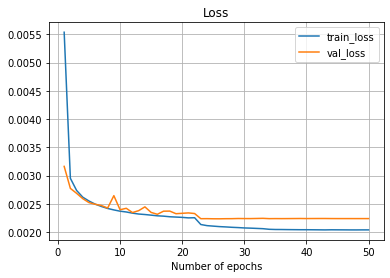

In [ ]:
plot_history(hist)

Final score on the test set. Better than Convolutional autoencoder.

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, model.predict(x_test_blurred)).numpy()

0.0022404054